In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_path = '/content/drive/MyDrive/train'
test_path = '/content/drive/MyDrive/test'
val_path = '/content/drive/MyDrive/valid'

In [3]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt

# VGG16

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image



    
train_datagen = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

training_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')


val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
val_set = val_datagen.flow_from_directory(
        val_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 2526 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


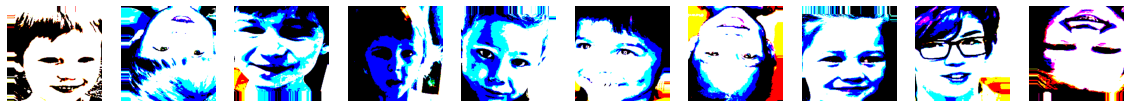

In [ ]:
aug_imgs,aug_labels =  next(training_set)

plt.figure(figsize=(20,7))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(aug_imgs[i])
  
plt.show();

In [ ]:
STEP_SIZE_TRAIN=training_set.n//32
STEP_SIZE_VALID=val_set.n//32
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

base_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

#base_model.trainable = False
for layer in base_model.layers:
  layer.trainable = False


base_model.summary()

78
6
58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                         

In [ ]:
#base_model.trainable = False


model = keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['acc'])

es = EarlyStopping(monitor='val_acc', mode='max', patience=5,  restore_best_weights=True)

filepath="/content/vgg16/" + "weights.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint, es]

history = model.fit(x=training_set,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_set,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40,
                  shuffle = True,callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 2)                 5

In [ ]:
model.load_weights('/content/vgg16/weights.h5')

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',shuffle=False)


model.evaluate(test_set)

Found 200 images belonging to 2 classes.
7/7 [==============================] - 18s 3s/step - loss: 0.3607 - acc: 0.8300


[0.3607027530670166, 0.8299999833106995]

In [ ]:
train_loss={v:k for k,v in enumerate(history.history['loss'])}
min_tloss = min(train_loss),train_loss[min(train_loss)]

val_loss={v:k for k,v in enumerate(history.history['val_loss'])}
min_vloss = min(val_loss),val_loss[min(val_loss)]

train_acc ={v:k for k,v in enumerate(history.history['acc'])}
max_tacc = max(train_acc),train_acc[max(train_acc)]

val_acc={v:k for k,v in enumerate(history.history['val_acc'])}
max_vacc = max(val_acc),val_acc[max(val_acc)]

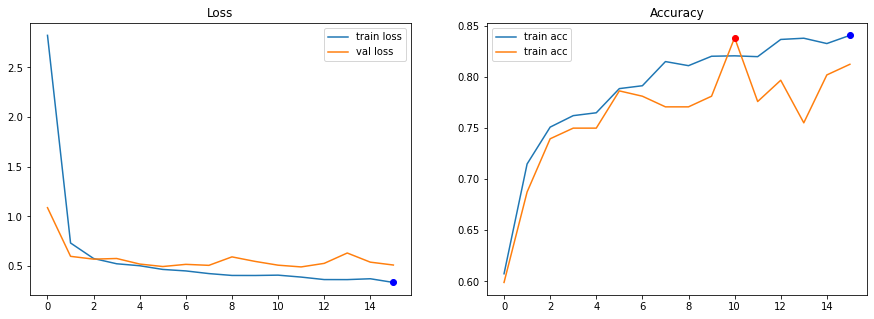

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label = 'val loss')
plt.plot(min_tloss[1],min_tloss[0],color='blue',marker='o')

plt.legend();

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['acc'],label='train acc')
plt.plot(history.history['val_acc'],label='train acc')
plt.plot(max_tacc[1],max_tacc[0],color='blue',marker='o')
plt.plot(max_vacc[1],max_vacc[0],color='red',marker='o')

plt.legend();

In [ ]:
#model.save('/content/vgg16/vgg16.hdf5')
model.save('/content/drive/MyDrive/ML Master/vgg16_3.hdf5')

# VGG19

In [ ]:
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D,GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

image_size = 299

train_datagen = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
        preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

training_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')


val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
val_set = val_datagen.flow_from_directory(
        val_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')


STEP_SIZE_TRAIN=training_set.n//32
STEP_SIZE_VALID=val_set.n//32
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)


# Xception

inputs = Input((image_size, image_size, 3))
backbone = tf.keras.applications.VGG19(input_tensor=inputs, include_top=False, weights="imagenet")
backbone.trainable = False


# model = keras.models.Sequential()
# model.add(backbone)
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(512, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model2 = keras.models.Sequential()
model2.add(backbone)
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(256, activation = 'relu'))
model2.add(tf.keras.layers.Dense(256, activation = 'relu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(256, activation = 'relu'))
model2.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model2.summary()

model2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

filepath="/content/vgg19/" + "weights.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint, es]

history = model2.fit(x=training_set,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_set,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40,
                  shuffle = True, callbacks=callbacks_list)

Found 2526 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
78
6
80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               10617088  
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                          

In [ ]:
model2.load_weights('/content/vgg19/weights.h5')


test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

model2.evaluate(test_set)

Found 200 images belonging to 2 classes.
7/7 [==============================] - 4s 534ms/step - loss: 0.4240 - accuracy: 0.8200


[0.4240066111087799, 0.8199999928474426]

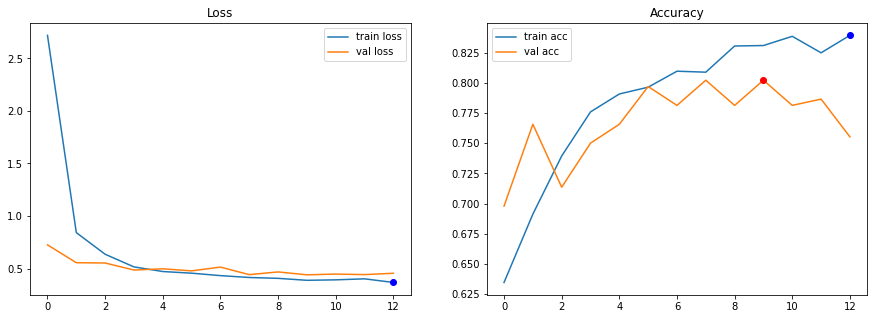

In [ ]:
train_loss={v:k for k,v in enumerate(history.history['loss'])}
min_tloss = min(train_loss),train_loss[min(train_loss)]

val_loss={v:k for k,v in enumerate(history.history['val_loss'])}
min_vloss = min(val_loss),val_loss[min(val_loss)]

train_acc ={v:k for k,v in enumerate(history.history['accuracy'])}
max_tacc = max(train_acc),train_acc[max(train_acc)]

val_acc={v:k for k,v in enumerate(history.history['val_accuracy'])}
max_vacc = max(val_acc),val_acc[max(val_acc)]



import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label = 'val loss')
plt.plot(min_tloss[1],min_tloss[0],color='blue',marker='o')

plt.legend();

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'],label='train acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.plot(max_tacc[1],max_tacc[0],color='blue',marker='o')
plt.plot(max_vacc[1],max_vacc[0],color='red',marker='o')

plt.legend();

# DenseNet

In [6]:
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D,GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

image_size = 224

train_datagen = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
        preprocessing_function=tf.keras.applications.densenet.preprocess_input)

training_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')


val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
val_set = val_datagen.flow_from_directory(
        val_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')


STEP_SIZE_TRAIN=training_set.n//32
STEP_SIZE_VALID=val_set.n//32
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)


base_model = tf.keras.applications.DenseNet121(include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))




for layer in base_model.layers:
   layer.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['acc'])

es = EarlyStopping(monitor='val_acc', mode='max', patience=5,  restore_best_weights=True)

filepath="/content/densenet/" + "weights.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint, es]


history = model.fit(x=training_set,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_set,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,
                  shuffle = True, callbacks=callbacks_list)

Found 2526 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
78
6
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              51381248  
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 2)                 10

In [8]:
model.load_weights('/content/densenet/weights.h5')


test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

model.evaluate(test_set)

Found 200 images belonging to 2 classes.
7/7 [==============================] - 3s 393ms/step - loss: 0.3022 - acc: 0.8650


[0.30218467116355896, 0.8650000095367432]

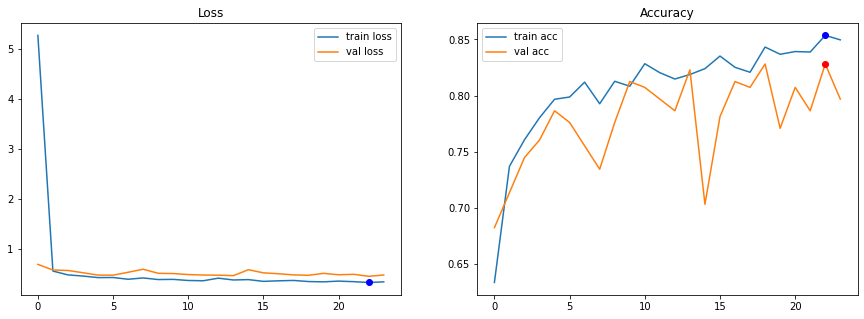

In [11]:
train_loss={v:k for k,v in enumerate(history.history['loss'])}
min_tloss = min(train_loss),train_loss[min(train_loss)]

val_loss={v:k for k,v in enumerate(history.history['val_loss'])}
min_vloss = min(val_loss),val_loss[min(val_loss)]

train_acc ={v:k for k,v in enumerate(history.history['acc'])}
max_tacc = max(train_acc),train_acc[max(train_acc)]

val_acc={v:k for k,v in enumerate(history.history['val_acc'])}
max_vacc = max(val_acc),val_acc[max(val_acc)]



import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label = 'val loss')
plt.plot(min_tloss[1],min_tloss[0],color='blue',marker='o')

plt.legend();

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['acc'],label='train acc')
plt.plot(history.history['val_acc'],label='val acc')
plt.plot(max_tacc[1],max_tacc[0],color='blue',marker='o')
plt.plot(max_vacc[1],max_vacc[0],color='red',marker='o')

plt.legend();